In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from numba import jit, prange, njit
from blimpy import Waterfall
import time
import random
import datetime
from synthetic import create_true, create_full_cadence, create_false, create_true_single_shot
from scipy import spatial
from numpy import dot
from numpy.linalg import norm
import math


In [2]:
%matplotlib inline
NUM_SAMPLES = 10000
plate = np.load('../../filtered.npy')

@jit(nopython=True)
def pre_proc(data):
    data = np.log(data)
    data= data - data.min()
    data = data/data.max()
    return data

@jit(parallel=True)
def load_data_ED(data):
    print(data.shape)
    data_transform =  np.zeros((data.shape[0],6, 16,256,1))
    for i in prange(data.shape[0]):
        data_transform[i,:,:,:,0]  = pre_proc(data[i,:,:,:] )
    return data_transform

def combine(data):
    new_data = np.zeros((data.shape[0]*data.shape[1],data.shape[2],data.shape[3],data.shape[4]))
    for i in prange(data.shape[0]):
        new_data[i*data.shape[1] : (i+1)*data.shape[1],:,:,:] = data[i,:,:,:,:]
    return new_data


data = abs(create_full_cadence(create_true, plate = plate, samples = NUM_SAMPLES, snr_base=300, snr_range=20,factor=0.1))
start = time.time()
data = combine(load_data_ED(data))
print(data.shape)
print(time.time()-start)
# data = combine(load_data_ED(abs(np.load("../../test_files/TRUE_DATA_GBT_1.npy"))))
# data[:,13:16,:,:] = data[:,0:3,:,:] 
print(time.time()-start)
# data = np.concatenate((data1,data2), axis=0)

SOM_data = abs(create_full_cadence(create_true, plate = plate, samples = 10000, snr_base=300, snr_range=20, factor=0.1))
start = time.time()
SOM_data = load_data_ED(SOM_data)
# SOM_data[:,:,13:16,:,:] = SOM_data[:,:,0:3,:,:] 

(10000, 6, 16, 256)
(60000, 16, 256, 1)
6.93331503868103
6.933384418487549
(10000, 6, 16, 256)


In [3]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, SOM_data, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")
        self.cluster_loss_tracker = keras.metrics.Mean(name="clustering_loss")
        self.SOM_data = SOM_data

    @tf.function
    def loss_diff(self, a,b):
        return 1/ self.loss_same(a,b)
   
    @tf.function
    def loss_same(self, a,b):
        norm = tf.math.reduce_euclidean_norm(a-b)
        return tf.math.reduce_sum(norm)
#         return tf.keras.losses.mean_squared_error(a, b)
    
    @tf.function
    def clustering(self):
        similarity = 0
        difference = 0
        same = 0
#         for i in range(self.SOM_data.shape[0]):
        a1 = self.encoder(self.SOM_data[:,0,:,:,:])[2]
        b = self.encoder(self.SOM_data[:,1,:,:,:])[2]
        a2 = self.encoder(self.SOM_data[:,2,:,:,:])[2]
        c = self.encoder(self.SOM_data[:,3,:,:,:])[2]
        a3 = self.encoder(self.SOM_data[:,4,:,:,:])[2]
        d = self.encoder(self.SOM_data[:,5,:,:,:])[2]

        difference += self.loss_diff(a1,b)
        difference += self.loss_diff(a1,c)
        difference += self.loss_diff(a1,d)

        difference += self.loss_diff(a2,b)
        difference += self.loss_diff(a2,c)
        difference += self.loss_diff(a2,d)

        difference += self.loss_diff(a3,b)
        difference += self.loss_diff(a3,c)
        difference += self.loss_diff(a3,d)

        same += self.loss_same(a1,a2)
        same += self.loss_same(a1,a3)
        same += self.loss_same(a2,a3)

        similarity += 3*same+difference
#         print(similarity)
        return similarity/self.SOM_data.shape[0]
    
    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]
    def train_step(self, data):
        x, y = data
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(x)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(y, reconstruction), axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            cluster_loss = self.clustering()
            total_loss = reconstruction_loss + 1*kl_loss +100*cluster_loss
            
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        self.cluster_loss_tracker.update_state(cluster_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
            "cluster_loss": self.cluster_loss_tracker.result()
        }

In [4]:
from tensorflow.python.client import device_lib
gpus = tf.config.experimental.list_physical_devices('GPU')

In [5]:
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [6]:
def sample_creation(inputs):
    z_mean = inputs[0]
    z_log_var = inputs[1]
    batch = tf.shape(z_mean)[0]
    dim = tf.shape(z_mean)[1]
    epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [13]:
def build_model():
    latent_dim = 6
    dens_lay = 512
    kernel = (3,3)
    encoder_inputs = keras.Input(shape=(16, 256, 1))
    x = layers.Conv2D(16, kernel, activation="relu", strides=2, padding="same")(encoder_inputs)
    x = layers.Conv2D(16, kernel, activation="relu", strides=1, padding="same")(x)
    x = layers.Conv2D(32, kernel, activation="relu", strides=2, padding="same")(x)
    x = layers.Conv2D(32, kernel, activation="relu", strides=1, padding="same")(x)
    x = layers.Conv2D(32, kernel, activation="relu", strides=1, padding="same")(x)
    x = layers.Conv2D(64, kernel, activation="relu", strides=2,padding="same")(x)
    x = layers.Conv2D(64, kernel, activation="relu", strides=1, padding="same")(x)
    x = layers.Conv2D(64, kernel, activation="relu", strides=1, padding="same")(x)
#     x = layers.Conv2D(128, kernel, activation="relu", strides=1, padding="same")(x)
#     x = layers.Conv2D(128, kernel, activation="relu", strides=1, padding="same")(x)
    x = layers.Conv2D(64, kernel, activation="relu", strides=2, padding="same")(x)
    x = layers.Flatten()(x)
    x = layers.Dense(dens_lay, activation="relu")(x)
    z_mean = layers.Dense(latent_dim, name="z_mean")(x)
    z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
    z = Sampling()([z_mean, z_log_var])
    encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
    encoder.summary()
    
    latent_inputs = keras.Input(shape=(latent_dim,))
    x = layers.Dense(dens_lay, activation="relu")(latent_inputs)
    x = layers.Dense(1* 16 * 64, activation="relu")(x)
    x = layers.Reshape((1,16, 64))(x)
    x = layers.Conv2DTranspose(64, kernel, activation="relu", strides=2,padding="same")(x)
#     x = layers.Conv2DTranspose(128, kernel, activation="relu", strides=1, padding="same")(x)
#     x = layers.Conv2DTranspose(128, kernel, activation="relu", strides=1, padding="same")(x)
    x = layers.Conv2DTranspose(64, kernel, activation="relu", strides=2, padding="same")(x)
    x = layers.Conv2DTranspose(64, kernel, activation="relu", strides=1, padding="same")(x)
    x = layers.Conv2DTranspose(64, kernel, activation="relu", strides=1, padding="same")(x)
    x = layers.Conv2DTranspose(32, kernel, activation="relu", strides=1, padding="same")(x)
    x = layers.Conv2DTranspose(32, kernel, activation="relu", strides=1, padding="same")(x)
    x = layers.Conv2DTranspose(32, kernel, activation="relu", strides=2, padding="same")(x)
    x = layers.Conv2DTranspose(16, kernel, activation="relu", strides=1, padding="same")(x)
    x = layers.Conv2DTranspose(16, kernel, activation="relu", strides=2, padding="same")(x)
    decoder_outputs = layers.Conv2DTranspose(1, kernel, activation="sigmoid", padding="same")(x)
    decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
    decoder.summary()

    vae = VAE(encoder, decoder, SOM_data[:1000, :,:,:,:])
    vae.compile(optimizer=keras.optimizers.Adam(lr=0.0005))
    return vae

strategy = tf.distribute.MirroredStrategy(cross_device_ops=tf.distribute.ReductionToOneDevice())
print("Number of devices: {}".format(strategy.num_replicas_in_sync))

with strategy.scope():
    model = build_model()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')
tensorflow      INFO     Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')
Number of devices: 4
Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 16, 256, 1)] 0                                            
__________________________________________________________________________________________________
conv2d_18 (Conv2D)              (None, 8, 128, 16)   160         in

In [ ]:
model.fit(data[:,:,:,:],data[:,:,:,:], epochs=2000, batch_size=10000)
# model.encoder.save("VAE-ENCODERv8.h5")
# model.decoder.save("VAE-DECODERv8.h5")

Epoch 1/2000
6/6 [==============================] - 45s 840ms/step - loss: 2932.7194 - reconstruction_loss: 2831.5134 - kl_loss: 0.0035 - cluster_loss: 0.9770
Epoch 2/2000
6/6 [==============================] - 5s 839ms/step - loss: 2875.6923 - reconstruction_loss: 2775.0120 - kl_loss: 1.0481 - cluster_loss: 0.8963
Epoch 3/2000
6/6 [==============================] - 5s 841ms/step - loss: 2468.5752 - reconstruction_loss: 2354.5144 - kl_loss: 20.9177 - cluster_loss: 0.6657
Epoch 4/2000
6/6 [==============================] - 5s 832ms/step - loss: 2238.0132 - reconstruction_loss: 2181.3445 - kl_loss: 13.9913 - cluster_loss: 0.5070
Epoch 5/2000
6/6 [==============================] - 5s 830ms/step - loss: 2154.0788 - reconstruction_loss: 2110.8252 - kl_loss: 15.2742 - cluster_loss: 0.4198
Epoch 6/2000
6/6 [==============================] - 5s 840ms/step - loss: 2103.5319 - reconstruction_loss: 2069.9297 - kl_loss: 13.5657 - cluster_loss: 0.3681
Epoch 7/2000
6/6 [=============================

In [10]:
model.fit(data[:,:,:,:],data[:,:,:,:], epochs=2000, batch_size=8000)
# model.encoder.save("VAE-ENCODERv8.h5")
# model.decoder.save("VAE-DECODERv8.h5")

Epoch 1/3000
8/8 [==============================] - 4s 437ms/step - loss: 2032.4356 - reconstruction_loss: 1989.1211 - kl_loss: 24.3191 - cluster_loss: 0.6478
Epoch 2/3000
8/8 [==============================] - 4s 444ms/step - loss: 2029.5039 - reconstruction_loss: 1985.6270 - kl_loss: 23.1727 - cluster_loss: 0.6044
Epoch 3/3000
8/8 [==============================] - 4s 444ms/step - loss: 2026.7400 - reconstruction_loss: 1982.9598 - kl_loss: 23.4434 - cluster_loss: 0.5691
Epoch 4/3000
8/8 [==============================] - 4s 454ms/step - loss: 2025.9661 - reconstruction_loss: 1980.8013 - kl_loss: 24.1319 - cluster_loss: 0.5391
Epoch 5/3000
8/8 [==============================] - 4s 558ms/step - loss: 2023.4354 - reconstruction_loss: 1978.3700 - kl_loss: 23.9565 - cluster_loss: 0.5139
Epoch 6/3000
8/8 [==============================] - 4s 561ms/step - loss: 2020.8099 - reconstruction_loss: 1976.4071 - kl_loss: 24.7484 - cluster_loss: 0.4922
Epoch 7/3000
8/8 [============================

In [11]:
model.encoder.save("VAE-ENCODERv9.h5")
model.decoder.save("VAE-DECODERv9.h5")

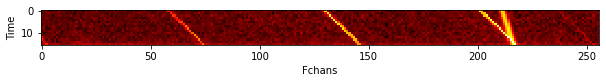

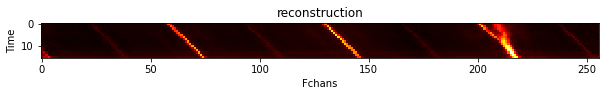

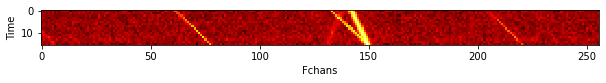

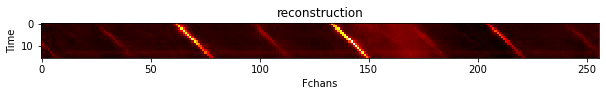

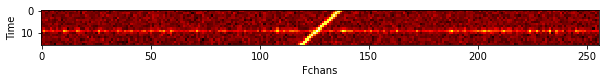

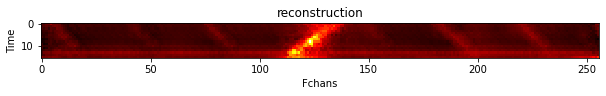

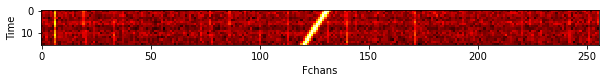

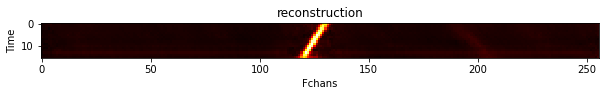

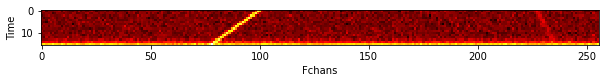

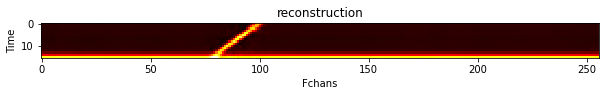

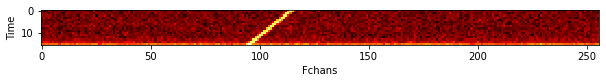

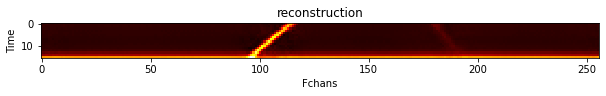

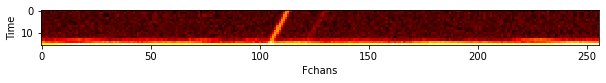

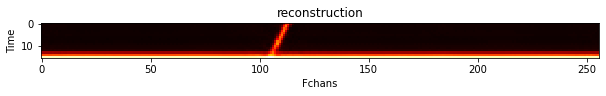

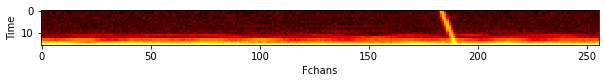

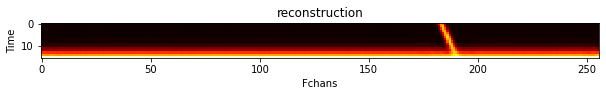

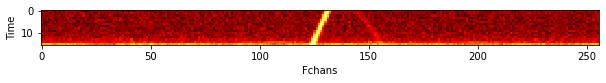

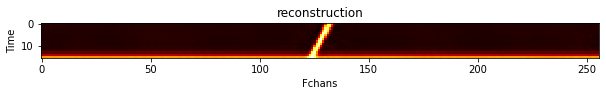

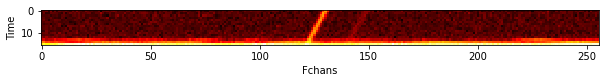

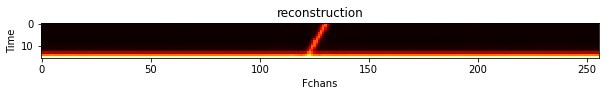

In [12]:
%matplotlib inline
import random 
for i in range(10):
    index = int(random.random()*1000)
    plot_data = data[index:index+1,:,:]
    plt.figure(figsize=(10,4))
    plt.xlabel("Fchans")
    plt.ylabel("Time")
    plt.imshow(plot_data[0,:,:,0], interpolation='nearest', cmap=plt.get_cmap('hot'))
    plt.show()
  
    stuff = model.encoder.predict(plot_data)
    sample = sample_creation(stuff)
    reconstruction = model.decoder.predict(sample)
    plt.figure(figsize=(10,4))
    plt.title("reconstruction")
    plt.xlabel("Fchans")
    plt.ylabel("Time")
    plt.imshow(reconstruction[0,:,:,0], interpolation='nearest', cmap=plt.get_cmap('hot'))
#     print("-----------------------------------------------")

In [90]:
model.encoder.save("VAE-ENCODERv6.h5")
model.decoder.save("VAE-DECODERv6.h5")

In [ ]:
%matplotlib inline
import random

for i in range(10):
    sample = np.array([[1,i,1,1,1,1]]) 
    reconstruction = model.decoder.predict(sample)
    print(reconstruction.max())
    plt.figure(figsize=(10,4))
    plt.title("Reconstruction")
    plt.xlabel("Fchans")
    plt.ylabel("Time")
    plt.imshow(reconstruction[0,:,:,0], interpolation='nearest')

In [ ]:
model.encoder.save("VAE-ENCODER_newtraining.h5")
model.decoder.save("VAE-DECODER_newtraining.h5")